# Practical 7: IMDB movie review - deep learning sequence models for text classification


We have seen the text analysis onn Amazon review data in practical 4, where Logistic Regression (LR) and SVMs were used to classification of the Amanzon food review (text) into 2 classes (positive or negative). In this practical we are going to try out convolutional neural networks (CNNs), and recurrent neural networks, in particular Long Short-Term Memory (LSTM) networks. You can also try out other types of models (e.g. Transformers) for comparison. 

This worksheet is originated from Keras'example:

https://keras.io/examples/nlp/text_classification_from_scratch/

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

- Note: You might wish to use a machine with accelerated hardware e.g. suitable GPU (often Nvidia GPU in Colab, Kaggle, virtual machines on google cloud platform, or your local machine) to speed up the training. In Colab, simply go to the top menu: Runtime - change RuntimeType to add a GPU. 


Preparing text data
deep learning models requires vectorising (i.e. transforming) text into numeric tensors. 

- Standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
- Split the text into units (called tokens), such as characters, words, or groups of words. This is called tokenization.
- Convert each such token into a numerical vector, usually involving first indexing all tokens present in the data, and then transforming into a vector of ints or a dense float vector. 

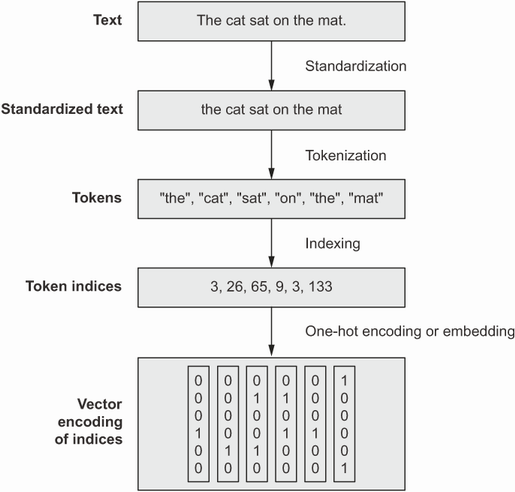

Figure 1. Text transformation for deep learning models (source: F. Chollet, Deep learning with python (2nd Ed.), 2022)

## Word embedding


Word embedding is a technique for converting or projecting the words into a vector representation such that words with similar meaning would be closer in the vector space, and thus can be understood by machine learning algorithms. Word embedding can be learned using neural networks (in form of supervised learning), often set to be the first layers of the network. It can be used for feature extraction or dimensionality reduction for the subsequent tasks of machine learning algorithms. 

Word embeddings are low-dimensional (often e.g. 128/256/1024-dimensional for a large vocabulary of e.g. 20k tokens) floating-point dense vectors (as opposed to sparse vectors for one-hot encoding).


There are two ways to obtain word embeddings: 
- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). Word vectors are learned in the same way you learn the weights of a neural network. 
- Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. There are various word embedding models available to use such as [word2vec](https://code.google.com/archive/p/word2vec/) and [GloVe](https://nlp.stanford.edu/projects/glove), and the pretrained models that have been trained on large amount of documents. 

#### Shortcoming of Bag-of-words (BOW) Methods
Recall that in practical 4, we used BOW or Term-Frequency inverse document frequency (TFIDF) to represent the review comments on Amazon product. However these methods ignore the order and the context of the words. 

Whereas word2vec model learns a word by predicting a word's surrounding context in a sentence. 

![Work2Vec Training Models](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/Word2Vec-Training-Models.png)
    Figure 1. Word2Vec Training Models Architectures (Continuous Bag-of-words vs Skip-Gram), Taken from “Efficient Estimation of Word Representations in Vector Space”, 2013"


More can be found about word embedding in the slides Lec13-Dimensionality reduction or the tutorials:
https://machinelearningmastery.com/what-are-word-embeddings/
and https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


Instead of work2vec models, today we will work on neural network (CNNs or RNNs) text classifiers with learnable embedding layers.

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

## Download and prepare IMDB dataset

The example below shows how to do text classification starting from raw text (as a set of text files on disk). We demonstrate the workflow on the IMDB sentiment classification dataset (unprocessed version). We use the `TextVectorization` layer for word splitting & indexing.

In [2]:
## Download the data and inspect the data structure
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 80.2M    0 16384    0     0   8375      0  2:47:24  0:00:01  2:47:23  8380
  0 80.2M    0 81920    0     0  28769      0  0:48:44  0:00:02  0:48:42 28784
  0 80.2M    0  224k    0     0  58422      0  0:23:59  0:00:03  0:23:56 58439
  0 80.2M    0  432k    0     0  88423      0  0:15:51  0:00:05  0:15:46 88455
  0 80.2M    0  704k    0     0   119k      0  0:11:28  0:00:05  0:11:23  140k
  1 80.2M    1 1104k    0     0   157k      0  0:08:41  0:00:07  0:08:34  215k
  1 80.2M    1 1520k    0     0   192k      0  0:07:07  0:00:07  0:07:00  284k
  2 80.2M    2 2128k    0     0   240k      0  0:05:41  0:00:08  0:05:33  386k
  3 80.2M    3 2832k    0     0   285k      0  0:04

In [2]:
# The aclImdb folder contains a train and test subfolder:
!ls aclImdb
!ls aclImdb/train
#!ls aclImdb/test
# Only interested in pos/neg and thus delete the rest
!rm -r aclImdb/train/unsup 

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Inspect text for a review from train subfolder
!cat aclImdb/train/pos/0_9.txt

'cat' is not recognized as an internal or external command,
operable program or batch file.


We can use the `tf.keras.preprocessing.text_dataset_from_directory` to
generate a labeled [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object from a set of text files on disk in class-specific folders.

When using the `validation_split` & `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation & training splits you get have no overlap.

In [4]:
batch_size = 32

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1234,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1234,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# raw_train/val/test_ds: tensorflow.dataset object
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}") 
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 75000 files belonging to 3 classes.
Using 60000 files for training.
Found 75000 files belonging to 3 classes.
Using 15000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 1875
Number of batches in raw_val_ds: 469
Number of batches in raw_test_ds: 782


In [5]:
# Take a look at a few (e.g. 5) examples from the training set in batch 1.

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'SEX WISH was actually released (minus ten minutes of more, ahem, \'extreme\' footage) here in the UK back in the early days of the video boom, and caused a tabloid storm in a teacup when it allegedly inspired a copycat murder case. Strangely enough, the papers brushed this ultra-disturbing flick under the carpet in their headlong rush to get the comparatively innocuous likes of FROZEN SCREAM and NIGHT OF THE DEMON canned, and the film has been all but forgotten as a result. I jumped at the chance to watch it on a DVD-RW and spent most of the film\'s duration with my jaw on the floor. It\'s not so much politically incorrect as utterly demented, a triple-X take on Michael Winner\'s DEATH WISH (did the title kind of give the game away as far as inspiration was concerned?) with hardcore sex and some truly nasty violence thrown into an already bubbling brew of seventies sleaze. If you don\'t consider yourself to be squeamish, this may force you to think again. By the time SEX WISH is over

**Question**

Discuss the preprocessing needed for the text based on the above inspection. 

In [ ]:
from tensorflow.keras.layers import TextVectorization
import string
import re

# Custom standardization function to remove HTML tags.
# Default function can do lowercase and punctuation stripping only.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Set word embedding hyper-parameters :
max_features = 20000
embedding_dim = 128
max_seq_len = 400 # set a fixed sequence length for CNNs

# instantiate our text vectorization layer 
# and map strings to integers, so we set our 'output_mode' to 'int'.
# here 
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=max_seq_len,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`, although vectorize_layer.vocabulary can be specified directly as well.
vectorize_layer.adapt(text_ds)

In [ ]:
# Check the vocabulary created from the text_ds via adapt, 
vectorize_layer.get_vocabulary()[0:50]

# Question: why token '' and '[UNK]' is needed in the vocabulary?
# 

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Build 1-D CNNs with learnable embedding for sentiment analysis

The keras Embedding layer (https://keras.io/layers/embeddings/) is best understood as a dictionary that maps integer indices (for specific words) to dense vectors, taking integers as input and return associated vectors. 

1D ConvNets, strictly analogous to 2D ConvNets, are a great fit for any sequence data that might contain repeated patterns in different locations within the sequence. 

In [ ]:
print('Build model...')

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

model.add(Embedding(max_features,
                    embedding_dim,
                    input_length=max_seq_len))

model.add(Dropout(0.2))

# we add a Convolution1D
model.add(Conv1D(filters=250,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling: 
model.add(GlobalMaxPooling1D())

# We add a fully connected desnse layer :
model.add(Dense(250))
model.add(Dropout(0.4))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [ ]:
# Check model architechture
model.summary() 


### Using callbacks
A callback is an object that is passed to the model in the call to fit() and called by the model at various points during training. It has access to the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model. Example uses include: 
- Model checkpointing—Saving the current state of the model at different points during training
- Using [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) for interactive visualisation.

In [ ]:
import datetime

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("1d-CNN", save_best_only=True),
]

history = model.fit(train_ds.cache(),
          validation_data=val_ds.cache(),
          epochs=3,
          callbacks=callbacks)

model = keras.models.load_model("1d-CNN") # load the 'best' model stored

### Plot the learning curves. 
To plot the learning curves, simply create a Pandas DataFrame with the history.history dict, then call its plot() method.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.show()

### Next, your turn

Evaluate the performance (accuracy and AUC) of the fitted models on the test data. You can simply use model.evaluate(x_test, y_test) or model.evaluate(test_ds) if a tensorflow.dataset test_ds is available.


To get a more detailed evaluation, you should obtained the prediction, and get the confusion matrix and classification report on the test data.  



In [ ]:
# Your code here
# 
# Hint: consider updating the metric in model.compile(metrics=[...]), 
# see https://keras.io/api/metrics/


**Exercise**

Play with the CNN architeture or other hyper-parameters on e.g.the parameters for the input or embedding, and see if you can improve the performance

Questions: 

1. How about using fully connected layers only (swapping the Covolutional layer with a dense layer)?

2. Can you build a logistic regression model from a neural network without hidden neuron?

3. why embedding layer is important in this case? Can you remove it?

4. Can you use a pretrained embedding in this case (see e.g. https://keras.io/examples/nlp/pretrained_word_embeddings/)?


## Other popular deep learning architectures for Natural Language Processing

Besides 1D-CNNs, other architectures such as RNNs(e.g. LSTMs), BERT, Transformer are also popular for sequence data, in particular, NLP here, Take a look at some of the examples here:

https://keras.io/examples/nlp/

Feel free to try these alternative architectures and compare?

In [ ]:
# Your code here
#
#

### Additional (optional) tutorials on Tranformer for language transltation (sequence-to-sequence modelling)

https://www.tensorflow.org/text/tutorials/transformer
